In [1]:
import nibabel as nib
import numpy as np
from matplotlib import pyplot as plt
import os
import json
import pandas as pd
from tqdm import tqdm

In [2]:
!dir

 El volumen de la unidad C es Local Disk
 El n£mero de serie del volumen es: 78AA-5A8A

 Directorio de C:\Users\n_940\Documents\UNAL\Temporal_U_Militar\desikan-killiany

12/08/2021  08:08 p. m.    <DIR>          .
12/08/2021  08:08 p. m.    <DIR>          ..
12/08/2021  08:04 p. m.    <DIR>          .ipynb_checkpoints
30/07/2021  01:17 p. m.             1.416 aal to HO.csv
22/07/2021  10:02 p. m.            13.538 aal-comparison-HO-noreg.csv
04/08/2021  09:02 p. m.            13.238 aal-comparison-HO.csv
04/08/2021  08:37 p. m.             5.923 aal_ho_difference.json
29/07/2021  11:15 p. m.           749.766 aal_transformed_roi.nii.gz
22/07/2021  10:14 p. m.            15.557 aicha-comparison-HO-noreg.csv
23/07/2021  05:47 p. m.            31.505 aicha-comparison-HO.csv
04/08/2021  09:02 p. m.           110.946 Atlas volumes regions.ipynb
13/07/2021  07:24 p. m.    <DIR>          atlas_correc
23/04/2021  05:05 p. m.           300.393 atlas_desikan_killiany.nii.gz
02/07/2021  08:36 a. 

In [3]:
template = nib.load('MNI152_T1_1mm_brain.nii.gz').get_fdata()
MNI_vol = (template>0).sum()
print('volumen MNI 152: ', (template>0).sum())
print('volumen todo archivo: ', (template>-1).sum())

volumen MNI 152:  1827095
volumen todo archivo:  7221032


In [4]:
desikan = nib.load('atlas_desikan_killiany.nii.gz').get_fdata()
num_region = 1028
desikan_reg = (desikan==num_region).sum()
print('desikan reg: ', desikan_reg)
print('desikan reg norm: ', (desikan_reg/MNI_vol))

desikan reg:  23562
desikan reg norm:  0.012895881166551274


In [5]:

desikan_new = nib.load('desikan_seg.nii.gz').get_fdata()
num_region = 18
desikan_reg_n = (desikan_new==num_region).sum()
print('new desikan reg: ', desikan_reg_n)
print('new desikan reg norm: ', desikan_reg_n/MNI_vol)

new desikan reg:  1213
new desikan reg norm:  0.0006638954186837575


In [6]:
harvard_oxford_cor = nib.load(os.path.join('harvard-oxford', 'HarvardOxford-cortl-maxprob-thr25-1mm.nii.gz')).get_fdata()
harvard_oxford_sub = nib.load(os.path.join('harvard-oxford', 'HarvardOxford-sub-maxprob-thr50-1mm.nii.gz')).get_fdata()

In [7]:
num_h_cort_reg = 51
harvard_cort_reg = (harvard_oxford_cor == num_h_cort_reg).sum()
print('harvard cort region: ', harvard_cort_reg)
print('harvard cort region norm: ', (harvard_cort_reg/MNI_vol))

harvard cort region:  5906
harvard cort region norm:  0.0032324537038303973


In [8]:
num_sub_reg = 20
harvard_sub_reg = (harvard_oxford_sub == num_sub_reg).sum()
print('harvard sub region: ', harvard_sub_reg)
print('harvard sub region norm: ', (harvard_sub_reg/MNI_vol))

harvard sub region:  2272
harvard sub region norm:  0.001243504032357376


In [9]:
def add_one_vox_pad(vol):
    h,w,k=vol.shape
    new_vol = np.zeros((h+1,w+1,k+1))
    new_vol[:h,:w,:k]=vol
    return new_vol

In [10]:
#aal = add_one_vox_pad(nib.load('new atlas/AAL3v1_for_SPM12 (1)/AAL3/ROI_MNI_V7_1mm.nii').get_fdata())
aal = nib.load('aal_transformed_roi.nii.gz').get_fdata()
aicha = add_one_vox_pad(nib.load('new atlas/AICHA_v2/AICHA/AICHA1mm.nii').get_fdata())
destrieux = nib.load('otros atlas/atlas_destrieux.nii.gz').get_fdata()
#neuro = nib.load('atlas_correc/neuromorphometrics_seg.nii.gz').get_fdata()

In [11]:
from nibabel.orientations import apply_orientation, io_orientation, ornt_transform
aal_raw = nib.load('new atlas/AAL3v1_for_SPM12 (1)/AAL3/ROI_MNI_V7_1mm.nii')
aal_affine = aal_raw.affine
io_aal = io_orientation(aal_affine)

print(io_aal)



[[0. 1.]
 [1. 1.]
 [2. 1.]]


In [12]:
ho_raw = nib.load(os.path.join('harvard-oxford', 'HarvardOxford-sub-maxprob-thr50-1mm.nii.gz'))
io_ho = io_orientation(ho_raw.affine)
transform = ornt_transform(io_aal,io_ho)
aal_transformed = add_one_vox_pad(apply_orientation(aal_raw.get_fdata(), transform))

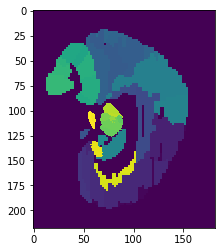

In [13]:
plt.imshow(aal_transformed[100,:,:])

## 2 Compute dice score between HO and DKT regions
We'll use binary masks to compute the dice score between a HO and a DKT region as $$ IoU(A,B) = \frac{A\cap B}{A\cup B} $$

In [14]:
def IoU(A,B):
    union = ((A+B)>0).astype(np.uint8)
    intersection = A*B
    return intersection.sum() / union.sum()

In [15]:
def dice_score(A,B):
    intersection = A*B
    num_elems = A.sum() + B.sum()
    return 2*intersection.sum() / num_elems

In [35]:
def probability_ref_A(A,B):
    intersection = A*B
    num_elems = A.sum()
    return intersection.sum() / num_elems

In [36]:
def probability_ref_B(A,B):
    intersection = A*B
    num_elems = B.sum()
    return intersection.sum() / num_elems

In [37]:
def select_atlas(atlas_name, atlases=[harvard_oxford_cor, harvard_oxford_sub, desikan_new,
                                     aal, aicha, destrieux]):
    if atlas_name=='harvard-cortical':
        return atlases[0]
    if atlas_name=='harvard-sub':
        return atlases[1]
    if atlas_name=='desikan':
        return atlases[2]
    if atlas_name=='aal':
        return atlases[3]
    if atlas_name=='aicha':
        return atlases[4]
    if atlas_name=='destrieux':
        return atlases[5]
    #if atlas_name=='neuro':
     #   return atlases[6]

In [38]:
def obtain_region_mask(region_group, template=template):
    mask = np.zeros(template.shape)
    for r in region_group:
        atlas = select_atlas(r['atlas'])
        num = r['region_number']
        mask+=((atlas==num).astype(np.uint8))
    return (mask>0).astype(np.uint8)

In [39]:
def compare_region_groups(A,B):
    gA = obtain_region_mask(A)
    gB = obtain_region_mask(B)
    return dice_score(gA, gB), IoU(gA,gB), probability_ref_A(gA, gB), probability_ref_B(gA, gB)

In [40]:
def obtain_region_volume(A):
    gA = obtain_region_mask(A)
    return gA.sum()

In [41]:
rA = [{'region_name': 'left amygdala', 'region_number': 10, 'atlas':'harvard-sub'}]
rB = [{'region_name': 'left amygdala', 'region_number': 18, 'atlas':'desikan'}]

In [42]:
compare_region_groups(rA, rB)

(0.6491392801251956,
 0.48053753475440225,
 0.5232088799192735,
 0.8549051937345424)

In [43]:
rA = [{'region_name': 'right amygdala', 'region_number': 10, 'atlas':'harvard-sub'}]
rB = [{'region_name': 'right amygdala', 'region_number': 18, 'atlas':'desikan'}]
compare_region_groups(rA, rB)

(0.6491392801251956,
 0.48053753475440225,
 0.5232088799192735,
 0.8549051937345424)

In [44]:
rA = [{'region_name': 'left frontal medial cortex', 'region_number': 50, 'atlas':'harvard-cortical'}]
rB = [{'region_name': 'ctx-lh-medialorbitofrontal', 'region_number': 2014, 'atlas':'desikan'}]
compare_region_groups(rA, rB)

(0.24954067145481879,
 0.14255725190839694,
 0.18467243510506798,
 0.3846549948506694)

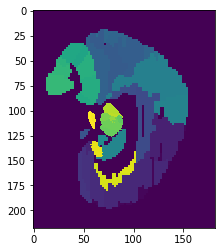

In [45]:
plt.imshow(aal[100,:,:])

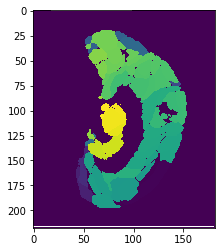

In [46]:
plt.imshow(aicha[100,:,:])

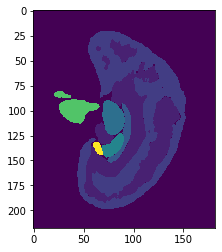

In [47]:
plt.imshow(harvard_oxford_sub[100,:,:])

## 3. Load json to do the experiment in a group of regions

In [48]:
with open('regions-comparison-interest.json') as f:
    data = json.load(f)

In [51]:
results_dice = {'region':[], 'dice_score':[], 'prob_ref_A':[], 'prob_ref_B':[],'Harvard volume':[], 'Desikan volume':[]}
for region in data:
    region_dict = data[region]
    comparison = compare_region_groups(region_dict['A'], region_dict['B'])
    results_dice['region'].append(region)
    results_dice['dice_score'].append(comparison[0])
    results_dice['prob_ref_A'].append(comparison[-2])
    results_dice['prob_ref_B'].append(comparison[-1])
    #results_dice['IoU'].append(comparison[1])
    results_dice['Harvard volume'].append(obtain_region_volume(region_dict['A']))
    results_dice['Desikan volume'].append(obtain_region_volume(region_dict['B']))
    

In [52]:
display(pd.DataFrame(results_dice).sort_values(by='dice_score', ascending=False))

,region,dice_score,prob_ref_A,prob_ref_B,Harvard volume,Desikan volume
1,right amygdala,0.668132,0.535211,0.888889,2272,1368
0,left amygdala,0.649139,0.523209,0.854905,1982,1213
4,"right supramarginal gyrus, anterior division",0.321297,0.242030,0.477771,6305,3194
12,Right frontal medial cortex,0.249541,0.184672,0.384655,4045,1942
3,"right cingulate gyrus, anterior division",0.207064,0.116161,0.952271,10649,1299
11,Left frontal medial cortex,0.203003,0.154079,0.297455,3641,1886
8,Left frontal pole,0.190047,0.107169,0.838460,55697,7119
6,"Right temporal fusiform cortex, anterior division",0.187140,0.272610,0.142471,2322,4443
9,Right frontal pole,0.184941,0.104831,0.784255,64809,8663
13,Left juxtapositional lobule cortex,0.168885,0.242804,0.129469,5906,11076


# Compare HO regions with DKT, Destrieux, Neuro, AAL, Aicha

In [53]:
with open('regions-comparison-interest.json') as f:
    data=json.load(f)

In [54]:
def generate_res_dict_atlas(index, name, atlas):
    return [{'region_name' : name, 'region_number' : index, 'atlas' : atlas}]

In [56]:
atlases_data = [{'atlas':'aal' ,'csv': 'new atlas/AAL3v1_for_SPM12 (1)/AAL3/labels.csv'}]
               #{'atlas':'aicha', 'csv':'new atlas/AICHA_v2/AICHA/labels.csv'}]

harvard_names = [data[r]['A'][0]['region_name'] for r in data]

for a in atlases_data:
    
    atlas_df = pd.read_csv(a['csv'])
    
    keys = atlas_df['name'].values
    vals = [[] for key in keys]
    res_dataframe = dict(zip(keys, vals))
    
    atlas_name = a['atlas']
    
    for r in data:
        A = data[r]['A']
        for index, name in zip(atlas_df['index'].values, tqdm(atlas_df['name'].values)):
            B = generate_res_dict_atlas(index, name, atlas_name)
            metric = compare_region_groups(A,B)[-1]
            res_dataframe[name].append(metric)
    
    
    res_f_df = pd.DataFrame(res_dataframe)
    res_f_df.index = harvard_names
    res_f_df.to_csv(atlas_name+'-comparison-HO-ref-B.csv')

 99%|███████████████████████████████████████████████████████████████████████████████▌| 165/166 [01:34<00:00,  1.74it/s]


## 4. Compare HO regions with all DKT

In [62]:
with open('regions-comparison-interest.json') as f:
    data=json.load(f)

In [63]:
desikan_labels = pd.read_csv('desikan_labels.csv')
display(desikan_labels.head())
print('len desikan: ', len(desikan_labels))

,index,name
0,0,Unknown
1,2,Left-Cerebral-White-Matter
2,4,Left-Lateral-Ventricle
3,5,Left-Inf-Lat-Vent
4,7,Left-Cerebellum-White-Matter


len desikan:  113


In [64]:
discard_desikan = [0,2,7,8,24,41,46,47]
filtered_desikan = desikan_labels[np.logical_not(desikan_labels['index'].isin(discard_desikan))]
print('len desikan filtered: ', len(filtered_desikan))

len desikan filtered:  105


In [65]:
def generate_res_dict_desikan(index, name):
    return [{'region_name' : name, 'region_number' : index, 'atlas' : 'desikan'}]

In [66]:
keys = filtered_desikan['name'].values
vals = [[] for key in keys]
dataframe = dict(zip(keys, vals))

for r in data:
    A = data[r]['A']
    for index, name in zip(filtered_desikan['index'].values, tqdm(filtered_desikan['name'].values)):
        B = generate_res_dict_desikan(index, name)
        dice, _ = compare_region_groups(A,B)
        dataframe[name].append(dice)

 99%|███████████████████████████████████████████████████████████████████████████████▏| 104/105 [00:30<00:00,  3.40it/s]


In [67]:
harvard_names = [data[r]['A'][0]['region_name'] for r in data]

In [68]:
comparison_regions = pd.DataFrame(dataframe)
comparison_regions.index = harvard_names
display(comparison_regions)
comparison_regions.to_csv('comparison_regions_dice.csv')

,Left-Lateral-Ventricle,Left-Inf-Lat-Vent,Left-Thalamus-Proper,Left-Caudate,Left-Putamen,Left-Pallidum,3rd-Ventricle,4th-Ventricle,Brain-Stem,Left-Hippocampus,...,ctx-rh-rostralanteriorcingulate,ctx-rh-rostralmiddlefrontal,ctx-rh-superiorfrontal,ctx-rh-superiorparietal,ctx-rh-superiortemporal,ctx-rh-supramarginal,ctx-rh-frontalpole,ctx-rh-temporalpole,ctx-rh-transversetemporal,ctx-rh-insula
left amygdala,0.0,0.004494,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.015403,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
right amygdala,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000413,0.0,0.021075
"left cingulate gyrus, anterior division",0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
"right cingulate gyrus, anterior division",0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.073578,0.000000,0.010925,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
"right supramarginal gyrus, anterior division",0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.000000,0.000000,0.000000,0.0,0.000638,0.241526,0.000000,0.000000,0.0,0.000000
"left superior temporal gyrus, anterior division",0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
"Right temporal fusiform cortex, anterior division",0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
Left supracalcarine cortex,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
Left frontal pole,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
Right frontal pole,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.000000,0.108847,0.053333,0.0,0.000000,0.000000,0.011487,0.000000,0.0,0.000000
